# Counting Road Fatalities as part of Tidy Tuesday for April 22, 2025

 (00:00) |            | Building CmdStan                     

<Axes: xlabel='fatalities_count', ylabel='Count'>

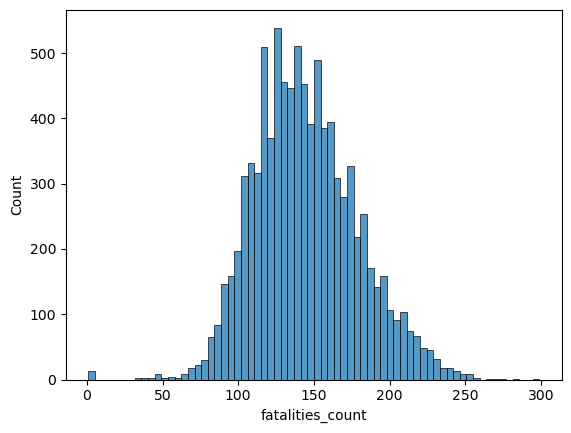

In [1]:
# import libraries
import pandas as pd # for everything
import numpy as np    # so pandas doesn't fail
import seaborn as sns   # viz                    
import matplotlib.pyplot as plt # more viz
from cmdstanpy import CmdStanModel # Stan! my man!
import statsmodels.api as sm # for OLS comps and gut checks
import patsy # for making OLS easier
import random # for setting the seed
import cmdstanpy # annoying jupyter/python thing so stan will run
cmdstanpy.rebuild_cmdstan() # see above comment



# set seed
random.seed(4232025)

# Load our data from Posit
df = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-04-22/daily_accidents_420.csv')

# take a quick peak
df.head()

# Convert the date column to datetime object
df['date'] = pd.to_datetime(df['date'])

# Make a count day of the week column
df['day_int'] = df['date'].dt.dayofweek

#  Make day of the week as a name
df['day_name'] = df['date'].dt.day_name()

# create a year Column
df['year'] = df['date'].dt.year

# And a month column for good measure
df['month'] = df['date'].dt.month

# let's look at the distribution of fatalities
sns.histplot(x=df['fatalities_count'])

/Users/jacobpstein/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


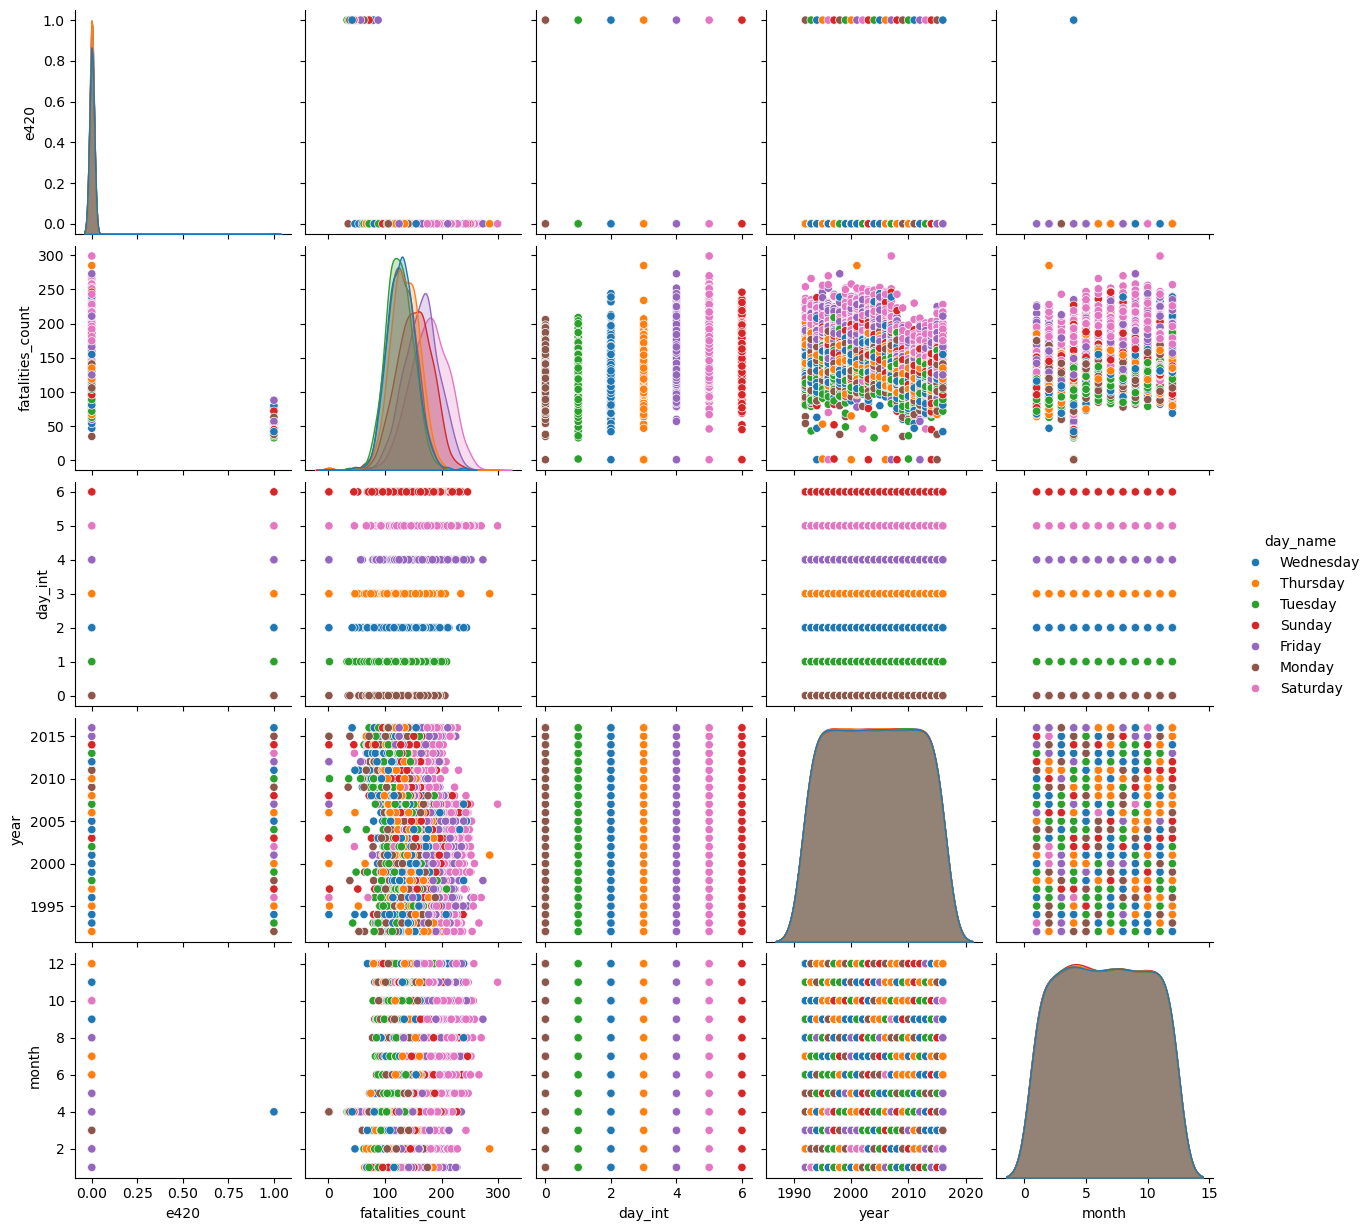

In [2]:
# and let's look at our relationships across the columns
sns.pairplot(df,  hue="day_name")
plt.show()

# looks like someone spilled a bunch of skittles

In [3]:

# Looks like there might be something going on with the day of the week
df.groupby(['day_name'])['fatalities_count'].mean().sort_values(ascending=False)
# So there are definitely higher deaths on average on Saturday



day_name
Saturday     177.847976
Friday       163.916794
Sunday       151.138720
Thursday     135.290618
Wednesday    129.012977
Monday       128.750191
Tuesday      125.362108
Name: fatalities_count, dtype: float64

In [4]:

# what about 420 and day?
df[df['e420']==True].groupby(['day_name'])['fatalities_count'].mean().sort_values(ascending=False)

# Let's see what that looks like


day_name
Friday       74.333333
Sunday       61.250000
Thursday     55.000000
Saturday     54.000000
Wednesday    54.000000
Monday       48.250000
Tuesday      40.250000
Name: fatalities_count, dtype: float64

/Users/jacobpstein/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


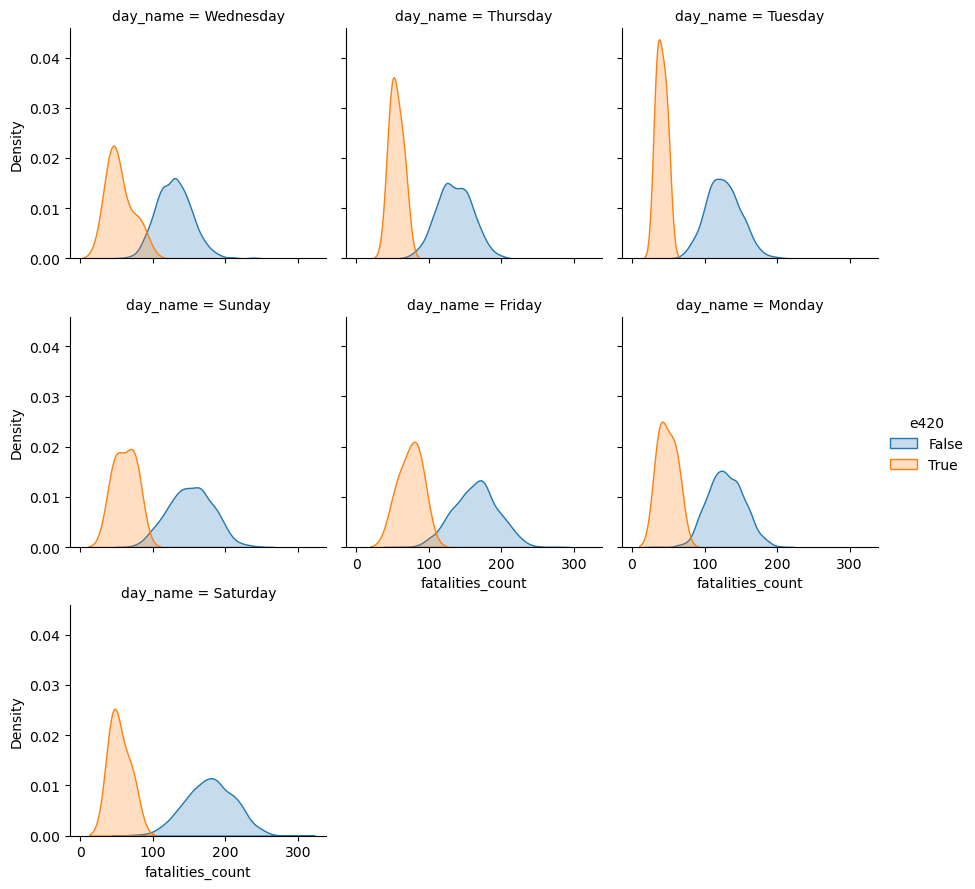

In [5]:

# make a facet grid
g = sns.FacetGrid(df, col="day_name", hue="e420", sharex=True, sharey=True, col_wrap=3)

# make a lil density plot by group
g.map_dataframe(sns.kdeplot, x="fatalities_count", fill=True)

# Add legends
g.add_legend()

plt.show()

## ~~~~~Model Time~~~~

So since we have count data, we want to use a poisson regression there's a ton of good stuff online about why, but it basically comes down to the fact that with OLS we could estimate *negative* fatalities, which makes no sense.

Poisson also handles zero counts better--we could also process our data with OLS and simply take the log, but log(0) takes you to the nether realm and Poisson avoids this.

After thinking about it for a bit, I'm not going to mess with the 420 thing because I am not sure there's much there.



In [3]:
# Let's check dispersion to see if we should fit a negative binomial
# variance-to-mean ratio
mean_fatalities = df['fatalities_count'].mean()
var_fatalities = df['fatalities_count'].var()
vmr_overall = var_fatalities / mean_fatalities

print(f'Overall Variance-to-Mean Ratio (VMR): {vmr_overall:.2f}')

# VMR by day of the week
vmr_by_day = df.groupby('day_name')['fatalities_count'].agg(['mean', 'var'])
vmr_by_day['VMR'] = vmr_by_day['var'] / vmr_by_day['mean']
print("\nVMR by day of the week:")
print(vmr_by_day[['VMR']])

Overall Variance-to-Mean Ratio (VMR): 8.04

VMR by day of the week:
                VMR
day_name           
Friday     5.953233
Monday     4.841116
Saturday   6.639483
Sunday     6.590794
Thursday   4.901048
Tuesday    4.716346
Wednesday  4.936125


In [6]:

# Because we're using Stan, we have to make some index variables
df['day_idx'] = df['day_name'].astype('category').cat.codes + 1
df['month_idx'] = df['month']
df['year_idx'] = df['year'] - df['year'].min() + 1

# Create our stan data object
stan_data = {
    'N': df.shape[0],
    'fatalities': df['fatalities_count'].values,
    'day': df['day_idx'].values,
    'month': df['month_idx'].values,
    'year': df['year_idx'].values,
    'N_day': df['day_idx'].nunique(),
    'N_month': df['month_idx'].nunique(),
    'N_year': df['year_idx'].nunique()
}

# fit out model!
stan_model = CmdStanModel(stan_file='April_22_2025.stan')
stan_fit = stan_model.sample(data=stan_data, chains=4, iter_sampling=1000, iter_warmup=1000, parallel_chains=4)

# now, we want to see if day of the week matters
# Pull out day effects
day_effects = stan_fit.draws_pd().filter(like='day_effect')
day_effects_mean = day_effects.mean()


# Cool, let's compare to OLS 
ols_formula = 'fatalities_count ~ C(day_name) + C(month) + C(year)'
ols_y, ols_X = patsy.dmatrices(ols_formula, data=df, return_type='dataframe')
ols_model = sm.OLS(ols_y, ols_X).fit()

# prep visualization
days = df['day_name'].astype('category').cat.categories

# poisson predicted means (already log(alpha) + day_effect)
day_effect_columns = [col for col in day_effects.columns if 'day_effect[' in col]
poisson_day_means = day_effects[day_effect_columns].mean().values  # Only 7 day effects
alpha_mean = stan_fit.draws_pd().filter(like='alpha').mean().values[0]
poisson_preds = np.exp(alpha_mean + poisson_day_means)


# OLS predicted means (set month and year to mean)
mean_month = df['month'].mean()
mean_year = df['year'].mean()

new_data = pd.DataFrame({
    'day_name': days,
    'month': [int(mean_month)] * len(days),
    'year': [int(mean_year)] * len(days)
})

# Generate the design matrix for the new data using the original design info
ols_X_pred = patsy.build_design_matrices([ols_X.design_info], new_data)[0]

# Predict using the OLS model
ols_preds = ols_model.predict(ols_X_pred)

# before we plot we need to order the days 
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

poisson_preds_ordered = [poisson_preds[list(days).index(d)] for d in day_order]
ols_preds_ordered = [ols_preds[list(days).index(d)] for d in day_order]

# actuals for comparison
observed_means = df.groupby('day_name')['fatalities_count'].mean().reindex(day_order)




10:21:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:35:38 - cmdstanpy - INFO - CmdStan done processing.


10:35:39 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (15.0%)
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 2 had 221 iterations at max treedepth (22.1%)
	Chain 3 had 202 iterations at max treedepth (20.2%)
	Chain 4 had 166 iterations at max treedepth (16.6%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [8]:
# give the dispersion stats, let's fit a new model
nb_model = CmdStanModel(stan_file='neg_bi.stan')
nb_fit = nb_model.sample(data=stan_data, chains=4, iter_sampling=1000, iter_warmup=1000, parallel_chains=4)

# Extract day effects
nb_day_effects = nb_fit.draws_pd().filter(like='day_effect[')
nb_day_means = nb_day_effects.mean().values
nb_alpha_mean = nb_fit.draws_pd().filter(like='alpha').mean().values[0]
nb_preds = np.exp(nb_alpha_mean + nb_day_means)

# Order predictions to match day_order
nb_preds_ordered = [nb_preds[list(days).index(d)] for d in day_order]


10:35:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:05:57 - cmdstanpy - INFO - CmdStan done processing.
12:05:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: neg_binomial_2_log_lpmf: Log location parameter is inf, but must be finite! (in 'neg_bi.stan', line 43, column 4 to line 45, column 11)
	Exception: neg_binomial_2_log_lpmf: Log location parameter is inf, but must be finite! (in 'neg_bi.stan', line 43, column 4 to line 45, column 11)
	Exception: neg_binomial_2_log_lpmf: Log location parameter is inf, but must be finite! (in 'neg_bi.stan', line 43, column 4 to line 45, column 11)
	Exception: neg_binomial_2_log_lpmf: Log location parameter is inf, but must be finite! (in 'neg_bi.stan', line 43, column 4 to line 45, column 11)
	Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'neg_bi.stan', line 43, column 4 to line 45, column 11)
	Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be positive finite! (in 'neg_bi.stan', line 43, column 4 to line

12:05:58 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 1 had 66 iterations at max treedepth (6.6%)
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 2 had 70 iterations at max treedepth (7.0%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 3 had 79 iterations at max treedepth (7.9%)
	Chain 4 had 2 divergent transitions (0.2%)
	Chain 4 had 82 iterations at max treedepth (8.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


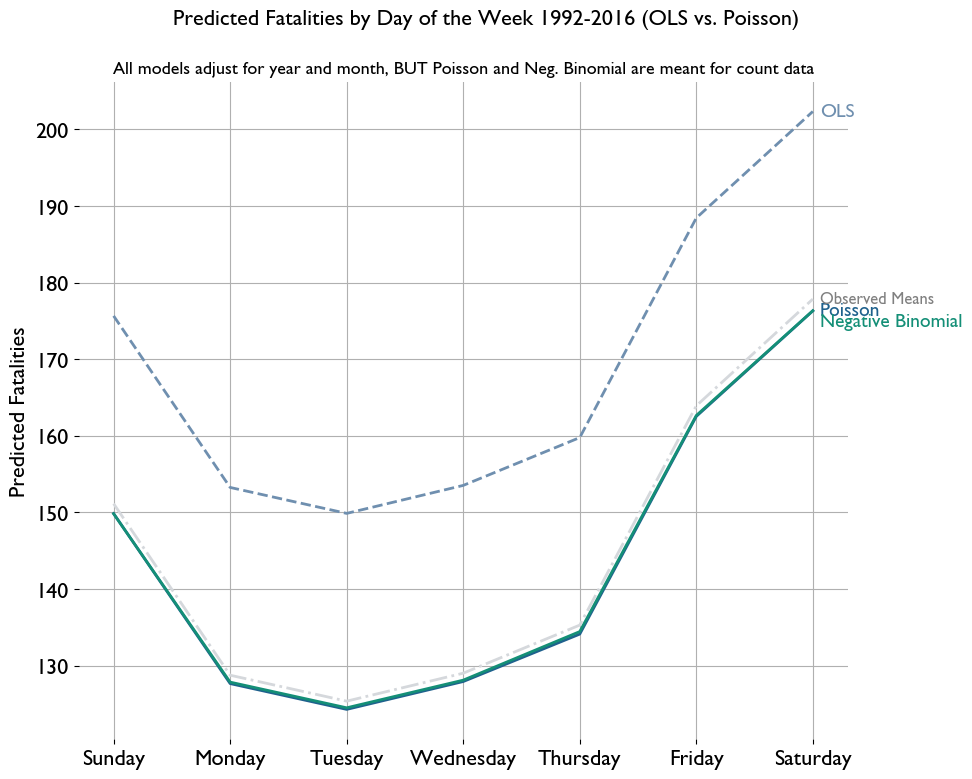

<Figure size 640x480 with 0 Axes>

In [22]:
# Set font
plt.rcParams["font.family"] = "Gill Sans"
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10, 8))

# Plot OLS
plt.plot(day_order, ols_preds_ordered, linestyle='--', color='#6F8FAF', linewidth=2)
plt.annotate('OLS', 
             xy=(len(day_order)-1, ols_preds_ordered[-1]),
             xytext=(5, 0), textcoords='offset points',
             va='center', ha='left', color='#6F8FAF',
             fontsize=14, fontweight='bold')

# Plot Poisson
plt.plot(day_order, poisson_preds_ordered, color='#1F618D', linewidth=2)
plt.annotate('Poisson', 
             xy=(len(day_order)-1, poisson_preds_ordered[-1]),
             xytext=(5, 0), textcoords='offset points',
             va='center', ha='left', color='#1F618D',
             fontsize=14, fontweight='bold')

# Plot Negative Binomial
plt.plot(day_order, nb_preds_ordered, color='#148F77', linewidth=2)
plt.annotate('Negative Binomial', 
             xy=(len(day_order)-1, nb_preds_ordered[-1]),
             xytext=(5, -8), textcoords='offset points',
             va='center', ha='left', color='#148F77',
             fontsize=14, fontweight='bold')

# Plot observed means
plt.plot(day_order, observed_means, linestyle='dashdot', color='#D5D8DC', linewidth=2)
plt.annotate('Observed Means', 
             xy=(len(day_order)-1, observed_means.iloc[-1]),
             xytext=(5, 0), textcoords='offset points',
             va='center', ha='left',
             fontsize=12, fontweight='bold', color='grey')

# Titles and formatting
plt.ylabel('Predicted Fatalities')
plt.suptitle('Predicted Fatalities by Day of the Week 1992-2016 (OLS vs. Poisson)', fontsize=16, ha='center')
plt.title('All models adjust for year and month, BUT Poisson and Neg. Binomial are meant for count data', ha='center', fontsize=13, fontweight='normal', style='italic')
plt.legend().set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.grid(True)
plt.tight_layout()
plt.show()

# Save
plt.savefig("ols_poisson_nb.png", dpi=300)
